# 네트워크 분석으로 라벨링

In [2]:
#불용어 읽어오기
stopwords_file_path = 'stopwords_dh_lastlast.txt'
stopwords = []
with open(stopwords_file_path, 'r', encoding='utf-8') as file:
    stopwords = [line.strip() for line in file.readlines()]


In [3]:
import pandas as pd
from konlpy.tag import Okt
from collections import Counter

df=pd.read_csv('data/hurtcombined.csv')
reason=df['판례내용_이유']

#NaN값 처리
reason= reason.fillna('')

#Okt호출
okt = Okt()

#정규화한 뒤 명사추출
normalized = reason.apply(lambda x: ' '.join(okt.nouns(okt.normalize(x))))

# 불용어 제거 및 LDA 적용
def remove_stopwords(text):
    tokens = text.split()  # 공백으로 나누기
    filtered_tokens = [word for word in tokens if word not in stopwords]  # 불용어 제거
    return ' '.join(filtered_tokens)  # 다시 문자열로 결합

normalized_cleaned = [remove_stopwords(' '.join([word for word in text.split() if word not in stopwords])
) for text in normalized]

In [23]:
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer

# TF-IDF 벡터라이저 적용
vectorizer = TfidfVectorizer(max_features=10000)
tfidf_matrix = vectorizer.fit_transform(normalized_cleaned)

# K-Means 클러스터링 수행 (k=6로 설정)
num_clusters = 6
km = KMeans(n_clusters=num_clusters, random_state=42)
km.fit(tfidf_matrix)

# 클러스터별 상위 단어 및 그 단어들의 TF-IDF 값 확인
order_centroids = km.cluster_centers_.argsort()[:, ::-1]
terms = vectorizer.get_feature_names_out()

cluster_top_terms = {}

print("클러스터별 상위 10개 단어:")
for i in range(num_clusters):
    print(f"\n클러스터 {i+1}:")
    top_terms = [terms[ind] for ind in order_centroids[i, :10]]
    cluster_top_terms[i] = top_terms  # 클러스터별 상위 10개 단어 저장
    # 클러스터의 상위 10개 단어의 TF-IDF 값 계산
    tfidf_values = [km.cluster_centers_[i, ind] for ind in order_centroids[i, :10]]
    mean_tf_idf = np.mean(tfidf_values)  # 평균 TF-IDF 값 계산
    for ind in order_centroids[i, :10]:  # 상위 10개의 단어
        print(f"단어: {terms[ind]} - TF-IDF 값: {km.cluster_centers_[i, ind]}")
    print(f"평균 TF-IDF 값: {mean_tf_idf:.4f}")  # 평균 TF-IDF 값 출력

tfidf_cluster_matrix = np.zeros((num_clusters, len(terms)))

for cluster in range(num_clusters):
    for term in cluster_top_terms[cluster]:  # 클러스터 번호가 1부터 시작하므로 인덱스 조정
        if term in terms:
            term_index = np.where(terms == term)[0][0]
            tfidf_cluster_matrix[cluster, term_index] = 1  # 클러스터에서의 단어 존재 여부를 1로 표시

# 클러스터 간 유사도 계산
similarity_matrix = cosine_similarity(tfidf_cluster_matrix)

클러스터별 상위 10개 단어:

클러스터 1:
단어: 파견 - TF-IDF 값: 0.46943741464036937
단어: 근로자 - TF-IDF 값: 0.2855510302959853
단어: 평화 - TF-IDF 값: 0.17913857246293308
단어: 제조업 - TF-IDF 값: 0.15756856754051282
단어: 산업 - TF-IDF 값: 0.14025010538674368
단어: 근로 - TF-IDF 값: 0.13876833121335827
단어: 안전 - TF-IDF 값: 0.13823720945407014
단어: 순찰 - TF-IDF 값: 0.12940715597031632
단어: 사업자 - TF-IDF 값: 0.11084957829691865
단어: 업주 - TF-IDF 값: 0.10923216715310541
평균 TF-IDF 값: 0.1858

클러스터 2:
단어: 보험 - TF-IDF 값: 0.5133425645522187
단어: 계약 - TF-IDF 값: 0.15621328640031415
단어: 보험금 - TF-IDF 값: 0.10980673599488054
단어: 지급 - TF-IDF 값: 0.09610241239352461
단어: 자동차 - TF-IDF 값: 0.09002607790942815
단어: 사고 - TF-IDF 값: 0.07797562062241851
단어: 손해 - TF-IDF 값: 0.050718897655563
단어: 회사 - TF-IDF 값: 0.04537426238539224
단어: 상해 - TF-IDF 값: 0.04227135046763567
단어: 사망 - TF-IDF 값: 0.039731959322494924
평균 TF-IDF 값: 0.1222

클러스터 3:
단어: 기초 - TF-IDF 값: 0.8002049001121525
단어: 다툼 - TF-IDF 값: 0.17522812381782404
단어: 지위 - TF-IDF 값: 0.0729461256530448
단어: 영상 - TF-IDF 값: 

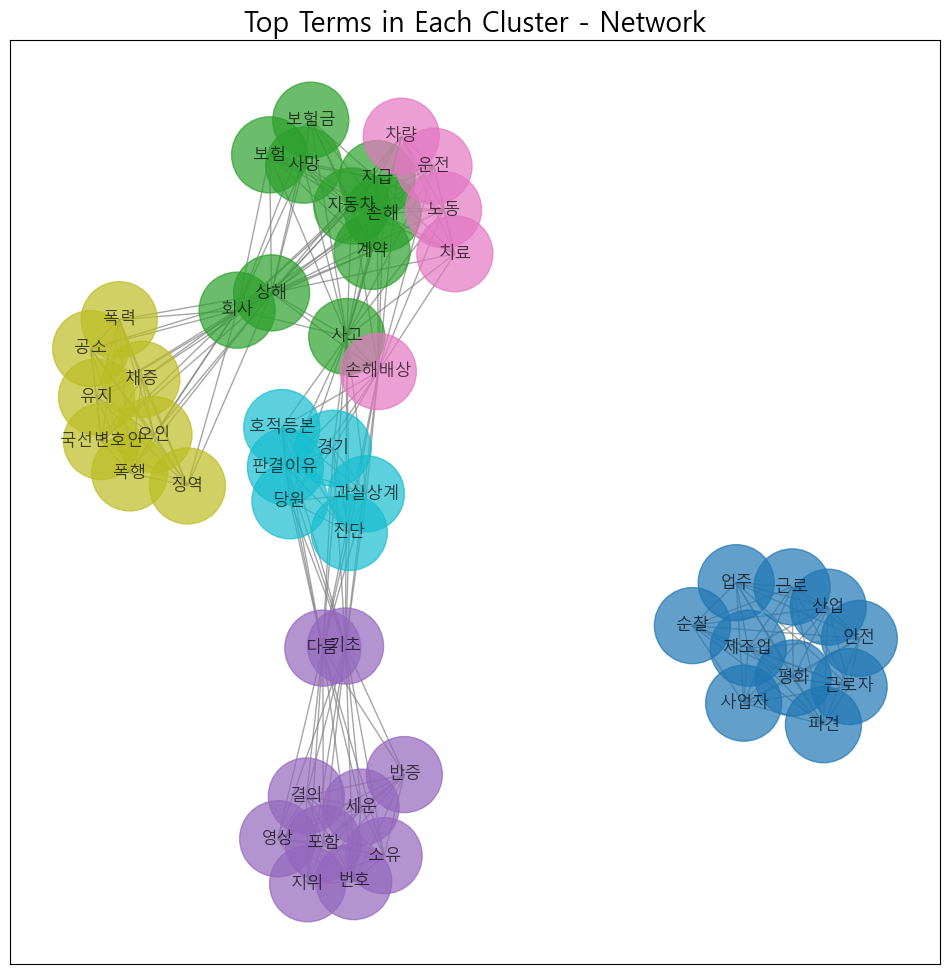

In [24]:
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx
from matplotlib import font_manager


# 한글 폰트 설정 (Windows에서의 Malgun Gothic)
font_path = 'C:/Windows/Fonts/malgun.ttf'  # 폰트 경로 설정
font_prop = font_manager.FontProperties(fname=font_path)


# 클러스터 색상 지정
num_clusters = len(cluster_top_terms)  # 클러스터 수에 맞게 설정
cluster_colors = plt.get_cmap('tab10', num_clusters)  # 색상 맵 생성

G = nx.Graph()

# 클러스터별 상위 단어들 사이의 엣지를 추가
for cluster, top_terms in cluster_top_terms.items():
    for i in range(len(top_terms)):
        for j in range(i + 1, len(top_terms)):
            G.add_edge(top_terms[i], top_terms[j], weight=1)  # 단순 엣지 추가 (공동 출현 가정)

# 노드 색상 맵 생성
color_map = []
for node in G.nodes():
    # 노드가 클러스터의 상위 단어인 경우 색상 지정
    for cluster_index, top_terms in cluster_top_terms.items():
        if node in top_terms:
            color_map.append(cluster_colors(cluster_index))  # 클러스터 색상 추가
            break
    else:
        color_map.append("gray")  # 클러스터 상위 단어가 아닌 노드는 회색으로 표시

# 네트워크 시각화
plt.figure(figsize=(12, 12))
pos = nx.spring_layout(G, k=0.5, iterations=50)

# 노드 및 엣지 그리기, 한글 폰트 적용
nx.draw_networkx(G, pos, with_labels=True, node_size=3000, node_color=color_map, font_size=12, font_color="black", edge_color="gray", alpha=0.7, font_family=font_prop.get_name())

# 제목에도 한글 폰트 적용
plt.title("Top Terms in Each Cluster - Network", fontproperties=font_prop, fontsize=20)
plt.show()

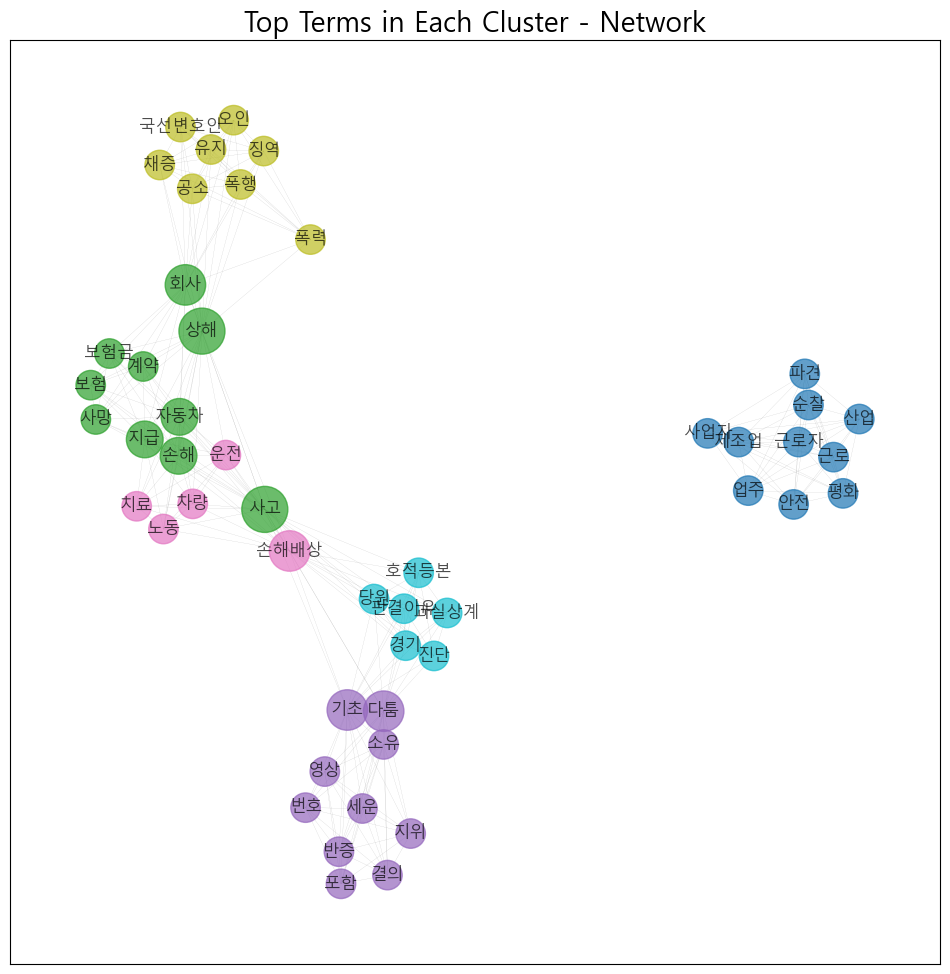

In [25]:
# 클러스터 색상 지정
num_clusters = len(cluster_top_terms)  # 클러스터 수에 맞게 설정
cluster_colors = plt.get_cmap('tab10', num_clusters)  # 색상 맵 생성

G = nx.Graph()

# 클러스터별 상위 단어들 사이의 엣지를 추가
for cluster, top_terms in cluster_top_terms.items():
    for i in range(len(top_terms)):
        for j in range(i + 1, len(top_terms)):
            G.add_edge(top_terms[i], top_terms[j], weight=1)  # 단순 엣지 추가 (공동 출현 가정)

# 노드 색상 맵 생성
color_map = []
for node in G.nodes():
    # 노드가 클러스터의 상위 단어인 경우 색상 지정
    for cluster_index, top_terms in cluster_top_terms.items():
        if node in top_terms:
            color_map.append(cluster_colors(cluster_index))  # 클러스터 색상 추가
            break
    else:
        color_map.append("gray")  # 클러스터 상위 단어가 아닌 노드는 회색으로 표시

# 네트워크 시각화
plt.figure(figsize=(12, 12))
pos = nx.spring_layout(G, k=0.5, iterations=50)

# 노드 크기 설정 (degree를 기반으로)
node_sizes = [d for n, d in G.degree()]

# 노드 및 엣지 그리기, 한글 폰트 적용
nx.draw_networkx(G, pos, with_labels=True, node_size=[d * 50 for d in node_sizes], node_color=color_map, font_size=12, font_color="black", edge_color="gray", alpha=0.7, width=0.1, font_family=font_prop.get_name())

# 제목에도 한글 폰트 적용
plt.title("Top Terms in Each Cluster - Network", fontproperties=font_prop, fontsize=20)
plt.show()

# 최적 K값 구하기

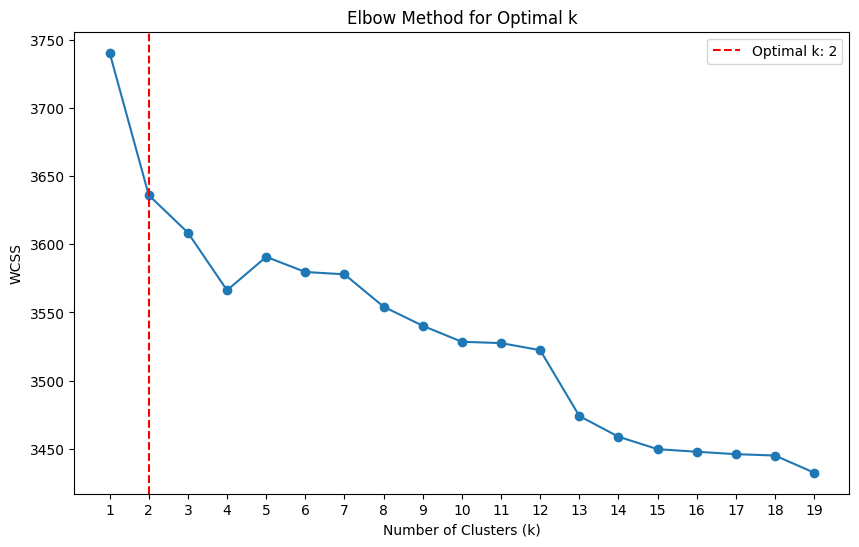

엘보우 포인트 k: 2


In [44]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import numpy as np

wcss = []
k_range = range(1, 20)  # k 값을 1에서 10까지 시도

for k in k_range:
    kmeans = KMeans(n_clusters=k,init='k-means++',random_state=42)
    kmeans.fit(tfidf_matrix)
    wcss.append(kmeans.inertia_)

plt.figure(figsize=(10, 6))
plt.plot(k_range, wcss, marker='o')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('WCSS')
plt.xticks(k_range)


# 엘보우 포인트 자동 감지
diff = np.diff(wcss)  # 1차 미분
diff2 = np.diff(diff<0)  # 2차 미분
elbow_index = np.argmin(diff2) + 2  # 엘보우 포인트 인덱스 (k는 2부터 시작)

# 엘보우 포인트 표시
plt.axvline(x=elbow_index, color='red', linestyle='--', label=f'Optimal k: {elbow_index}')
plt.legend()
plt.show()

print(f"엘보우 포인트 k: {elbow_index}")
#Wcss의 감소가 완만해지는 elbow 지점을 k=4~5이므로 k=4가 적절하다.

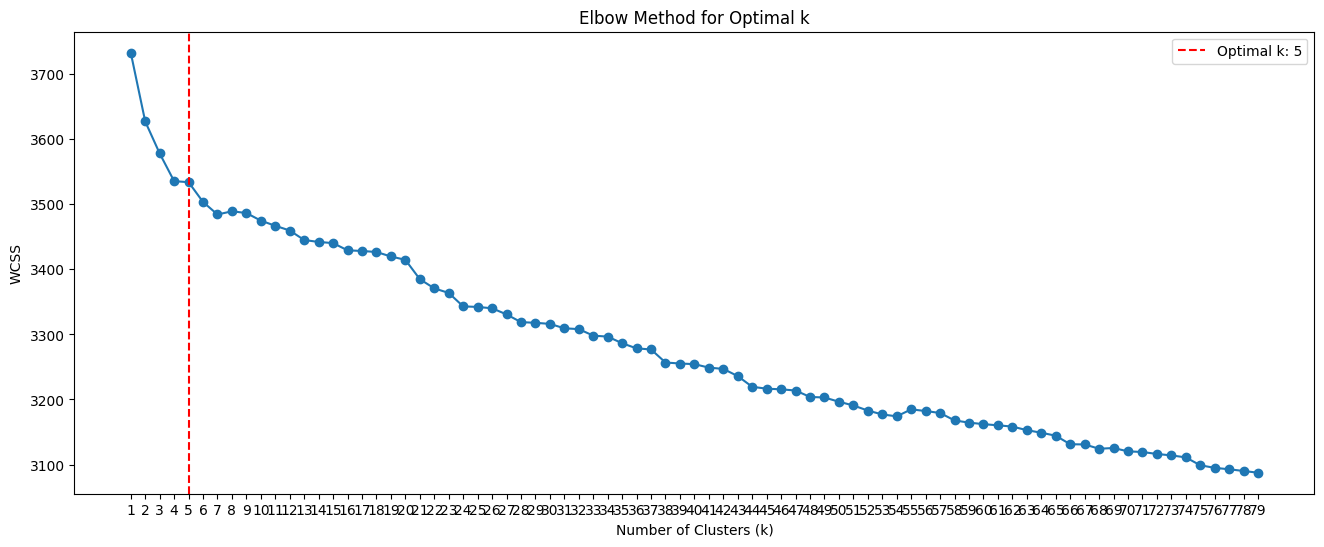

엘보우 포인트 k: 5


In [17]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import numpy as np

wcss = []
k_range = range(1, 80)  # k 값을 1에서 10까지 시도

for k in k_range:
    kmeans = KMeans(n_clusters=k,init='k-means++',random_state=42)
    kmeans.fit(tfidf_matrix)
    wcss.append(kmeans.inertia_)

plt.figure(figsize=(16, 6))
plt.plot(k_range, wcss, marker='o')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('WCSS')
plt.xticks(k_range)


# 엘보우 포인트 자동 감지
diff = np.diff(wcss)  # 1차 미분
diff2 = np.diff(diff)  # 2차 미분
elbow_index = np.argmin(diff2) + 2  # 엘보우 포인트 인덱스 (k는 2부터 시작)

# 엘보우 포인트 표시
plt.axvline(x=elbow_index, color='red', linestyle='--', label=f'Optimal k: {elbow_index}')
plt.legend()
plt.show()

print(f"엘보우 포인트 k: {elbow_index}")
#Wcss의 감소가 완만해지는 elbow 지점을 k=4~5이므로 k=4가 적절하다.

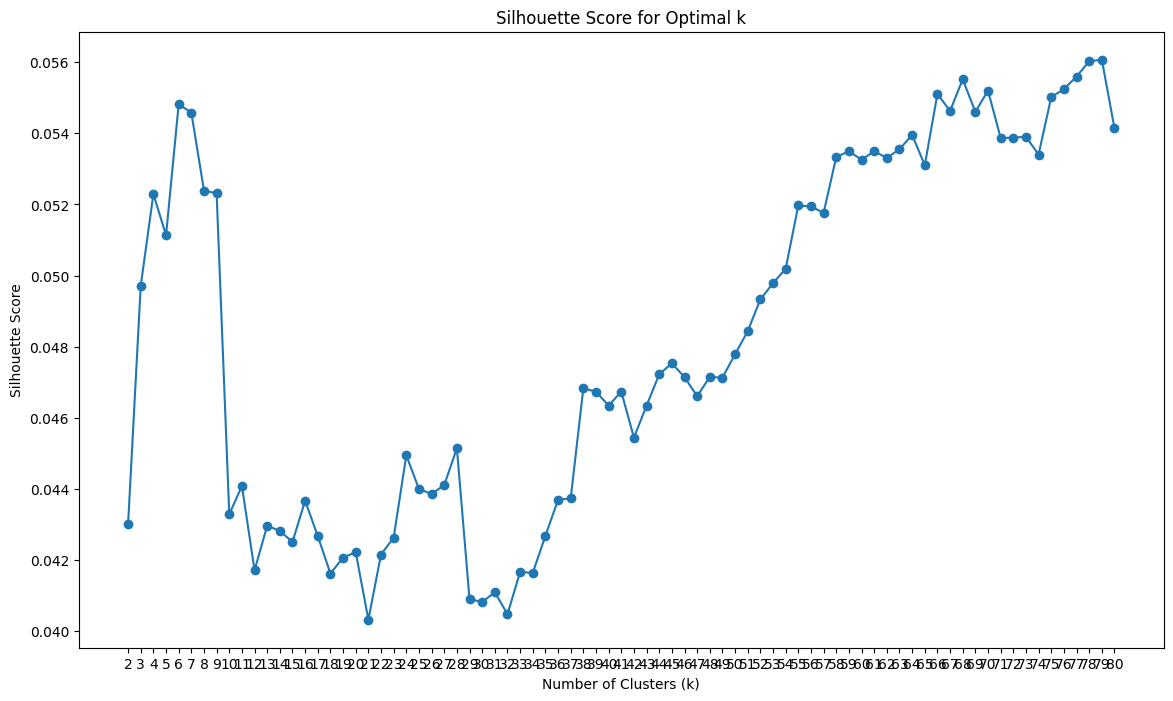

In [19]:
from sklearn.metrics import silhouette_score

silhouette_scores = []

for k in range(2, 81):  # k 값을 2에서 10까지 시도
    kmeans = KMeans(n_clusters=k,init='k-means++', random_state=42)
    kmeans.fit(tfidf_matrix)
    silhouette_scores.append(silhouette_score(tfidf_matrix, kmeans.labels_))

plt.figure(figsize=(14, 8))
plt.plot(range(2, 81), silhouette_scores, marker='o')
plt.title('Silhouette Score for Optimal k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.xticks(range(2,81))
plt.show()

# 실루엣 계수 해석:
# 0.5 이상: 잘 정의된 클러스터로 간주
# 0.25 ~ 0.5: 약간의 겹침이 있지만 여전히 유의미한 클러스터
# 0.25 이하: 클러스터링 결과가 좋지 않음

In [22]:
# 최적의 k 값 찾기
optimal_k = range(2, 81)[np.argmax(silhouette_scores)]
optimal_score = max(silhouette_scores)
print(optimal_k)

79


너무 많지 않은 k값중에서 적절한 k값은 실루엣 계수 계산에서는 k=6 정도가 적당하고 엘보우 포인트 구하는 것에서도 6정도면 나쁘지 않으므로 k=6으로 진행한다.

갭 통계량 (Gap Statistic)

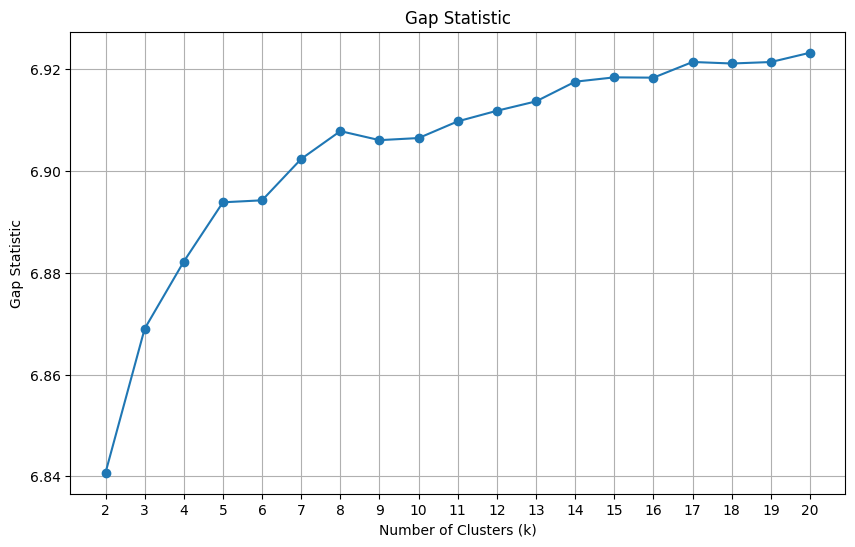

In [53]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

def gap_statistic(X, k_max):
    gaps = np.zeros(k_max - 1)
    for k in range(1, k_max):
        # Fit the model
        kmeans = KMeans(n_clusters=k, random_state=42)
        kmeans.fit(X)
        # WCSS for the observed data
        wcss = kmeans.inertia_

        # Generate random data and compute WCSS
        random_data = np.random.random_sample(size=X.shape)
        kmeans_random = KMeans(n_clusters=k, random_state=42)
        kmeans_random.fit(random_data)
        random_wcss = kmeans_random.inertia_

        # Gap statistic
        gaps[k - 1] = np.log(random_wcss) - np.log(wcss)

    return gaps


gaps = gap_statistic(tfidf_matrix, 20)

# Plotting the gap statistic
plt.figure(figsize=(10, 6))
plt.plot(range(2, 21), gaps, marker='o')
plt.title('Gap Statistic')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Gap Statistic')
plt.xticks(range(2, 21))
plt.grid()
plt.show()

다면체 분석 (Davies-Bouldin Index)

ㄴDBI 값 해석


DBI < 0.5: 클러스터 간의 분리도가 매우 높고, 클러스터 내의 응집도도 우수합니다. 이상적인 클러스터링 결과입니다.

0.5 ≤ DBI < 1.0: 클러스터 간의 분리도와 응집도가 적당한 수준입니다. 클러스터링이 괜찮지만 개선의 여지가 있을 수 있습니다.

DBI ≥ 1.0: 클러스터 간의 분리도가 낮고, 클러스터 내의 응집도가 떨어질 수 있습니다. 이 경우, 클러스터링 품질이 좋지 않다고 판단할 수 있습니다.

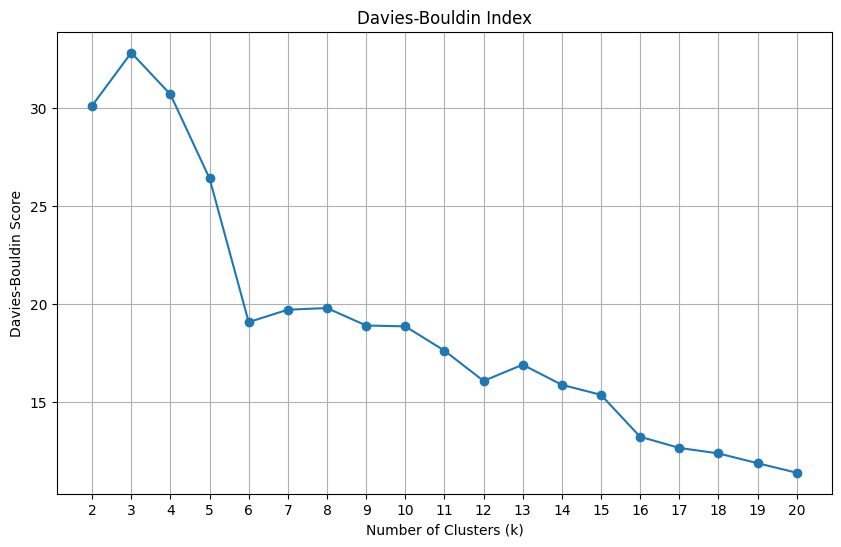

In [60]:
from sklearn.metrics import davies_bouldin_score
from sklearn.cluster import KMeans
import numpy as np
import matplotlib.pyplot as plt

def davies_bouldin_chunked(X, k_range, chunk_size=1000):
    db_scores = []
    
    for k in k_range:
        kmeans = KMeans(n_clusters=k, random_state=42)
        
        # 전체 데이터의 클러스터 레이블 저장
        labels = np.zeros(X.shape[0])
        
        # 데이터를 청크로 나누어 처리
        for i in range(0, X.shape[0], chunk_size):
            # 현재 청크 데이터 추출
            doc_chunk = X[i:i + chunk_size]
            
            # K-Means 클러스터링
            kmeans.fit(doc_chunk)
            chunk_labels = kmeans.labels_
            
            # 클러스터 레이블 저장
            labels[i:i + chunk_size] = chunk_labels
        
        # Davies-Bouldin score 계산
        db_index = davies_bouldin_score(X.toarray(), labels)
        db_scores.append(db_index)

    return db_scores

# TF-IDF 행렬을 사용하여 Davies-Bouldin Index 계산
db_scores = davies_bouldin_chunked(tfidf_matrix, range(2, 21))

# Plotting Davies-Bouldin Index
plt.figure(figsize=(10, 6))
plt.plot(range(2, 21), db_scores, marker='o')
plt.title('Davies-Bouldin Index')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Davies-Bouldin Score')
plt.xticks(range(2, 21))
plt.grid()
plt.show()

비율적 내적 거리 (Calinski-Harabasz Index)

ㄴ가장 높을 때 군집화가 잘된 것이다.

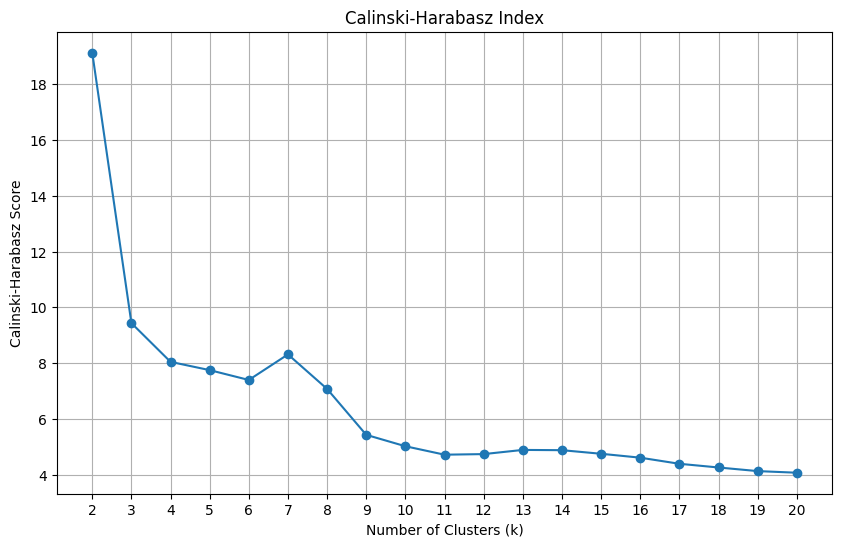

In [59]:
from sklearn.metrics import calinski_harabasz_score
from sklearn.cluster import KMeans
import numpy as np

def calinski_harabasz_chunked(X, k_range, chunk_size=1000):
    ch_scores = []
    for k in k_range:
        kmeans = KMeans(n_clusters=k, random_state=42)
        ch_index = []
        # 데이터셋을 청크로 나누어 처리
        for i in range(0, X.shape[0], chunk_size):
            chunk = X[i:i + chunk_size]
            kmeans.fit(chunk)
            labels = kmeans.labels_  # 클러스터 레이블
            ch_index.append(calinski_harabasz_score(chunk.toarray(), labels))  # 밀집행렬로 변환하여 계산
        # 평균값 계산
        ch_scores.append(np.mean(ch_index))

    return ch_scores

ch_scores = calinski_harabasz_chunked(tfidf_matrix, range(2, 21))

# Plotting Calinski-Harabasz Index
plt.figure(figsize=(10, 6))
plt.plot(range(2, 21), ch_scores, marker='o')
plt.title('Calinski-Harabasz Index')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Calinski-Harabasz Score')
plt.xticks(range(2, 21))
plt.grid()
plt.show()

호르스트 방법 (Hierarchical Clustering)

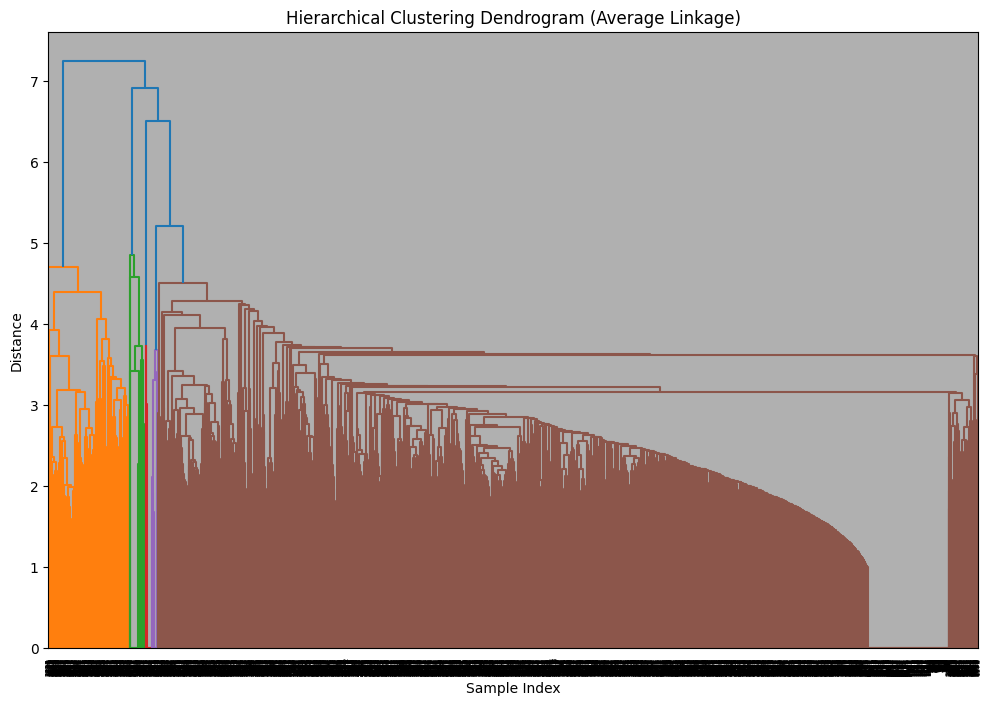

In [67]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.cluster.hierarchy as sch
from sklearn.metrics.pairwise import cosine_similarity

# TF-IDF 행렬이 sparse 형태인 경우 밀집 행렬로 변환하고 numpy array로 변환
dense_tfidf_matrix = np.asarray(tfidf_matrix.todense())

# 코사인 유사도 계산
cosine_similarities = cosine_similarity(dense_tfidf_matrix)

# 계층적 군집화 (average linkage 사용)
linkage_matrix = sch.linkage(1 - cosine_similarities, method='average')

# 덴드로그램 그리기
plt.figure(figsize=(12, 8))
dendrogram = sch.dendrogram(linkage_matrix)
plt.title('Hierarchical Clustering Dendrogram (Average Linkage)')
plt.xlabel('Sample Index')
plt.ylabel('Distance')
plt.grid()
plt.show()

In [70]:
# 샘플 데이터를 원본 문서로 출력
# documents는 원본 문서의 리스트라고 가정
for idx, doc in enumerate(documents):
    print(f"샘플 {idx}: {doc}")

NameError: name 'documents' is not defined

TF-IDF 상위 100 가지고 네트워크 분석 그리기

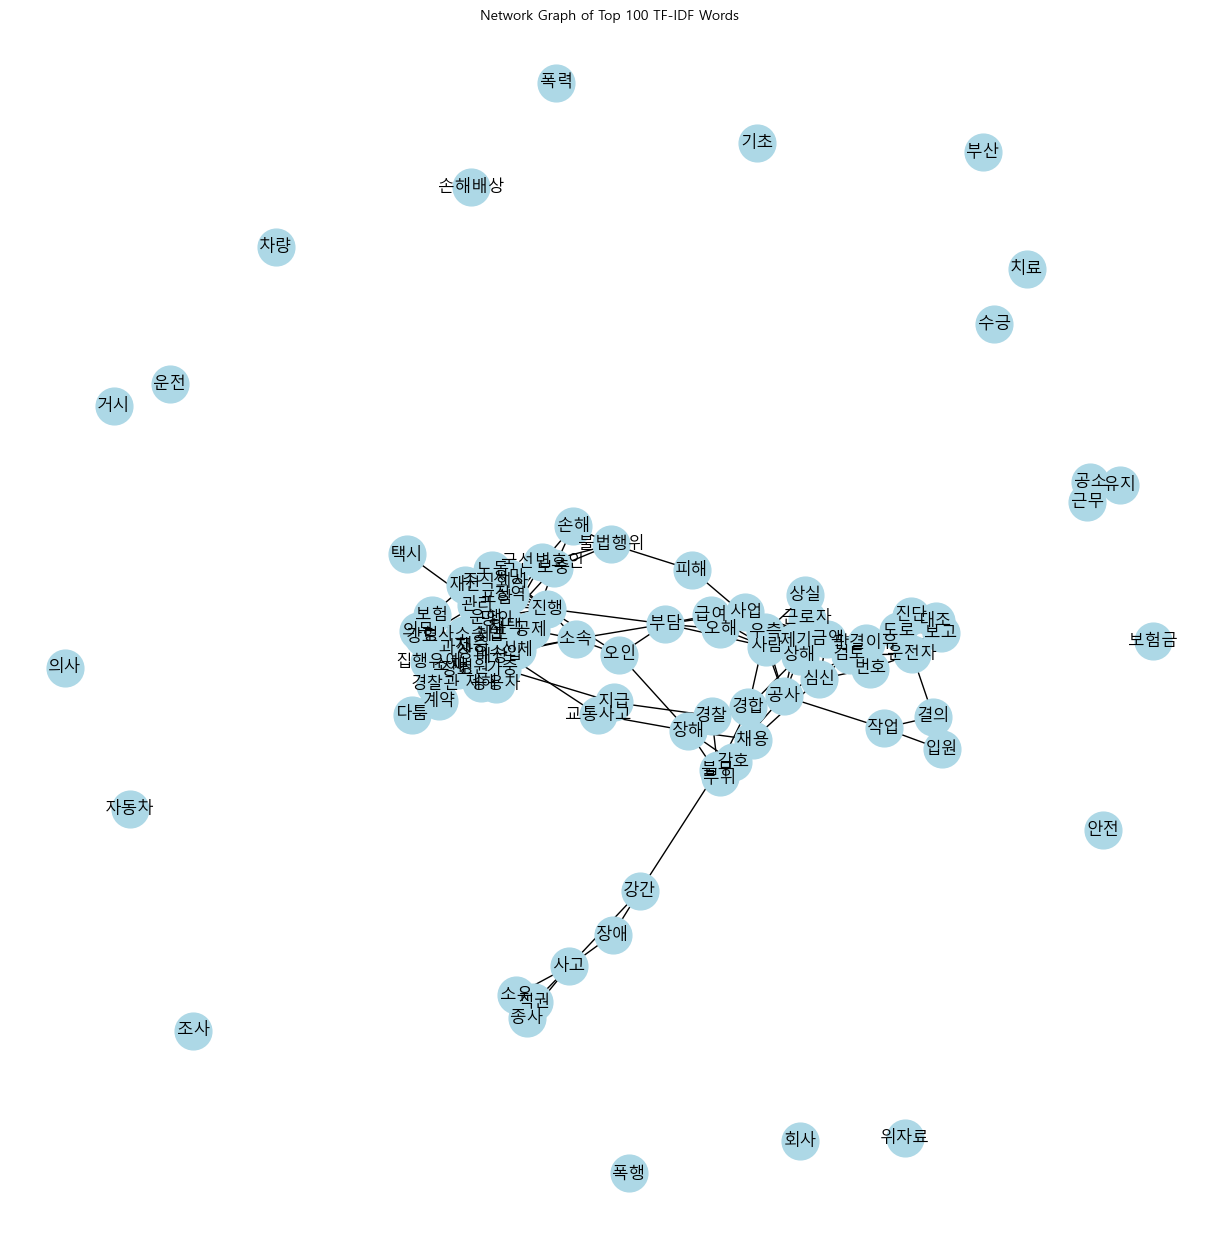

In [31]:
# 1. 상위 100개 단어 추출
mean_tfidf = np.mean(tfidf_matrix, axis=0)
top_100_indices = np.argsort(mean_tfidf.A1)[-100:]  # 상위 100개 단어 인덱스
top_100_words = vectorizer.get_feature_names_out()[top_100_indices]

# 2. 상위 100개 단어의 TF-IDF 벡터 추출
top_100_tfidf = tfidf_matrix[:, top_100_indices]

# 3. 상위 100개 단어 간의 유사도 행렬 생성
similarity_matrix = cosine_similarity(top_100_tfidf)

# 4. 네트워크 그래프 생성
G = nx.Graph()

# 상위 100개 단어를 노드로 추가
for idx, word in enumerate(top_100_words):
    G.add_node(word)

# 유사도가 0.3 이상인 경우 엣지 추가 (threshold 조정 가능)
threshold = 0.3
for i in range(len(top_100_words)):
    for j in range(i + 1, len(top_100_words)):
        if similarity_matrix[i, j] >= threshold:
            G.add_edge(top_100_words[i], top_100_words[j], weight=similarity_matrix[i, j])

# 5. 네트워크 시각화
plt.figure(figsize=(12, 12))
pos = nx.spring_layout(G)  # 레이아웃 설정
nx.draw(G, pos, with_labels=True, node_size=700, node_color='lightblue', font_family='Malgun Gothic')
plt.title('Network Graph of Top 100 TF-IDF Words',fontproperties=font_prop)
plt.show()

클러스터별 상위 10개 단어:

클러스터 1:
 파견
 근로자
 평화
 산업
 근로
 안전
 순찰
 업주
 엔비
 신우
 사출
 사업
 고용
 의무
 계약
 외주
 배려
 주가
 복지
 보호

클러스터 2:
 보험
 계약
 자동차
 보험금
 지급
 사고
 회사
 손해
 의무
 보험료
 상해
 금액
 가입
 차량
 사망
 상법
 대인배
 특약
 망인
 운전

클러스터 3:
 망인
 산소
 호흡
 혈증
 가제
 프로포폴
 마취
 을제
 수술
 포화
 투여
 곤란
 삽관술
 뇌손상
 정맥주사
 마취제
 도미
 환자
 맥박
 대학교

클러스터 4:
 기초
 손해배상
 폭행
 상해
 오인
 다툼
 징역
 국선변호인
 폭력
 회사
 유지
 공소
 채증
 오해
 의사
 강간
 직권
 채택
 형사소송법
 채용

클러스터 5:
 보험
 지급
 보험금
 사고
 급여
 장해
 재해
 계약
 사망
 자동차
 손해
 상해
 망인
 금액
 치료
 손해배상
 산재
 후유
 차량
 채권

클러스터 6:
 차량
 운전
 사고
 자동차
 도로
 운행
 승용차
 교통사고
 도주
 운전자
 진행
 도로교통법
 가중
 택시
 충격
 정차
 차선
 구호
 신호
 교통

클러스터 7:
 거시
 판결이유
 유지
 손해배상
 수행자
 당원
 배하
 과실상계
 옆집
 오빠
 국선
 공범
 채증
 대조
 개요
 오인
 운전사
 인천
 주임
 준용

클러스터 8:
 의심
 증명력
 합리
 형성
 형사재판
 간접
 살인
 간다
 여지
 배제
 증명
 의문
 경험칙
 고찰
 확신
 단독
 허용
 베란다
 제기
 설령

클러스터 9:
 보충
 경과
 유서
 도과
 거시
 지난
 국선변호인
 한도
 준비서면
 남편
 후의
 체포영장
 취사
 폭행
 채증
 노임
 간도
 산부인과
 수익
 경제범죄

클러스터 10:
 사고
 손해
 치료
 노동
 지급
 손해배상
 상실
 수입
 배상
 일용
 종사
 공제
 위자료
 상해
 병원
 불법행위
 재산
 장해
 의무
 입원


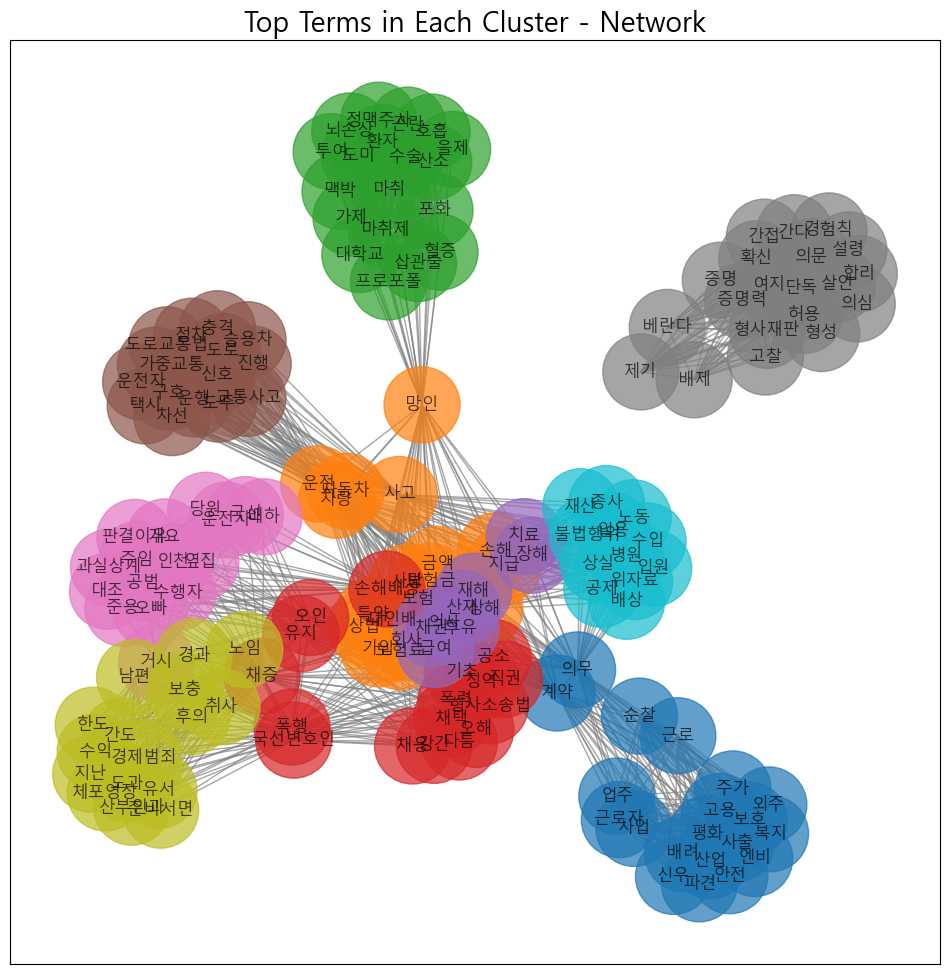

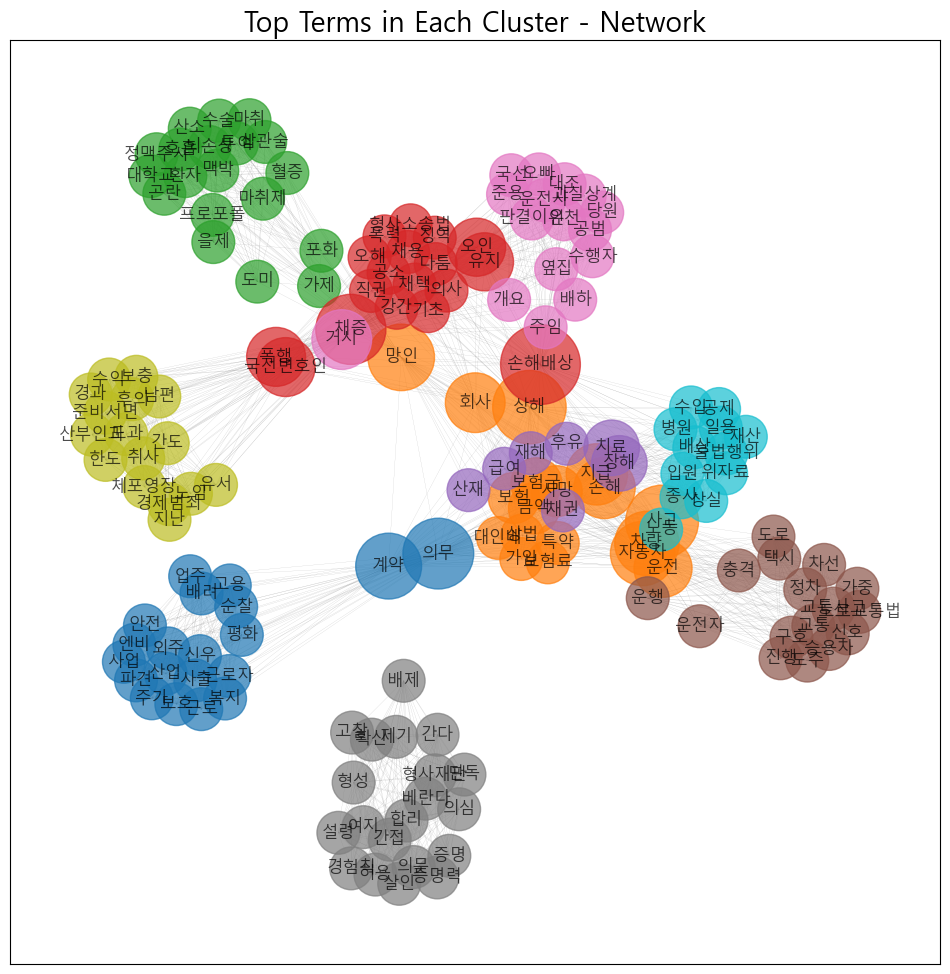

In [33]:
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# TF-IDF 벡터라이저 적용
vectorizer = TfidfVectorizer(max_df=0.95,min_df=2)
tfidf_matrix = vectorizer.fit_transform(normalized_cleaned)

# K-Means 클러스터링 수행 (k=10로 설정)
num_clusters = 10
km = KMeans(n_clusters=num_clusters, random_state=42)
km.fit(tfidf_matrix)

# 클러스터별 상위 단어 및 그 단어들의 TF-IDF 값 확인
order_centroids = km.cluster_centers_.argsort()[:, ::-1]
terms = vectorizer.get_feature_names_out()

cluster_top_terms = {}

print("클러스터별 상위 10개 단어:")
for i in range(num_clusters):
    print(f"\n클러스터 {i+1}:")
    top_terms = [terms[ind] for ind in order_centroids[i, :20]]
    cluster_top_terms[i] = top_terms  # 클러스터별 상위 10개 단어 저장
    for term in top_terms:
        print(f" {term}")

tfidf_cluster_matrix = np.zeros((num_clusters, len(terms)))

for cluster in range(num_clusters):
    for term in cluster_top_terms[cluster]:  # 클러스터 번호가 1부터 시작하므로 인덱스 조정
        if term in terms:
            term_index = np.where(terms == term)[0][0]
            tfidf_cluster_matrix[cluster, term_index] = 1  # 클러스터에서의 단어 존재 여부를 1로 표시

# 클러스터 간 유사도 계산
similarity_matrix = cosine_similarity(tfidf_cluster_matrix)


# 클러스터 색상 지정
num_clusters = len(cluster_top_terms)  # 클러스터 수에 맞게 설정
cluster_colors = plt.get_cmap('tab10', num_clusters)  # 색상 맵 생성

G = nx.Graph()

# 클러스터별 상위 단어들 사이의 엣지를 추가
for cluster, top_terms in cluster_top_terms.items():
    for i in range(len(top_terms)):
        for j in range(i + 1, len(top_terms)):
            G.add_edge(top_terms[i], top_terms[j], weight=1)  # 단순 엣지 추가 (공동 출현 가정)

# 노드 색상 맵 생성
color_map = []
for node in G.nodes():
    # 노드가 클러스터의 상위 단어인 경우 색상 지정
    for cluster_index, top_terms in cluster_top_terms.items():
        if node in top_terms:
            color_map.append(cluster_colors(cluster_index))  # 클러스터 색상 추가
            break
    else:
        color_map.append("gray")  # 클러스터 상위 단어가 아닌 노드는 회색으로 표시

# 네트워크 시각화
plt.figure(figsize=(12, 12))
pos = nx.spring_layout(G, k=0.5, iterations=50)

# 노드 및 엣지 그리기, 한글 폰트 적용
nx.draw_networkx(G, pos, with_labels=True, node_size=3000, node_color=color_map, font_size=12, font_color="black", edge_color="gray", alpha=0.7, font_family=font_prop.get_name())

# 제목에도 한글 폰트 적용
plt.title("Top Terms in Each Cluster - Network", fontproperties=font_prop, fontsize=20)
plt.show()


# 클러스터 색상 지정
num_clusters = len(cluster_top_terms)  # 클러스터 수에 맞게 설정
cluster_colors = plt.get_cmap('tab10', num_clusters)  # 색상 맵 생성

G = nx.Graph()

# 클러스터별 상위 단어들 사이의 엣지를 추가
for cluster, top_terms in cluster_top_terms.items():
    for i in range(len(top_terms)):
        for j in range(i + 1, len(top_terms)):
            G.add_edge(top_terms[i], top_terms[j], weight=1)  # 단순 엣지 추가 (공동 출현 가정)

# 노드 색상 맵 생성
color_map = []
for node in G.nodes():
    # 노드가 클러스터의 상위 단어인 경우 색상 지정
    for cluster_index, top_terms in cluster_top_terms.items():
        if node in top_terms:
            color_map.append(cluster_colors(cluster_index))  # 클러스터 색상 추가
            break
    else:
        color_map.append("gray")  # 클러스터 상위 단어가 아닌 노드는 회색으로 표시

# 네트워크 시각화
plt.figure(figsize=(12, 12))
pos = nx.spring_layout(G, k=0.5, iterations=50)

# 노드 크기 설정 (degree를 기반으로)
node_sizes = [d for n, d in G.degree()]

# 노드 및 엣지 그리기, 한글 폰트 적용
nx.draw_networkx(G, pos, with_labels=True, node_size=[d * 50 for d in node_sizes], node_color=color_map, font_size=12, font_color="black", edge_color="gray", alpha=0.7, width=0.1, font_family=font_prop.get_name())

# 제목에도 한글 폰트 적용
plt.title("Top Terms in Each Cluster - Network", fontproperties=font_prop, fontsize=20)
plt.show()

# N-gram 라벨링
ngram 뽑은 문장 옆에 ngram 단어쌍이 들어가는 새 열을 넣는다.

In [ ]:
import pandas as pd

# 예시 데이터프레임 생성
data = {
    '문장': [
        '자연어 처리를 배우는 것은 흥미롭다.',
        '인공지능 기술이 발전하고 있다.',
        '딥러닝은 머신러닝의 한 분야이다.'
    ]
}

df = pd.DataFrame(data)

# n-그램 생성 함수
def generate_ngrams(sentence, n):
    words = sentence.split()  # 문장을 단어로 분할
    return list(ngrams(words, n))  # n-그램 생성

# n-그램 생성 및 새로운 열에 추가
n = 2  # 예를 들어, 2-그램
df['n_grams'] = df['문장'].apply(lambda x: generate_ngrams(x, n))

# 결과 출력
print(df)

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

# n-그램을 포함한 TF-IDF 벡터라이저 설정
vectorizer = TfidfVectorizer(ngram_range=(1, 2), stop_words='english')

# 텍스트 데이터에 TF-IDF 적용
corpus = [
    "자연어 처리는 흥미로운 분야입니다.",
    "자연어 처리 기술은 다양한 분야에서 사용됩니다.",
    "텍스트 데이터 분석을 통해 유용한 정보를 얻을 수 있습니다."
]

tfidf_matrix = vectorizer.fit_transform(corpus)

# 피쳐 이름 확인
feature_names = vectorizer.get_feature_names_out()
print(feature_names)

# TF-IDF 값 확인
print(tfidf_matrix.toarray())

In [10]:
from sklearn.feature_extraction.text import TfidfVectorizer

# n-그램을 포함한 TF-IDF 벡터라이저 설정
vectorizer = TfidfVectorizer(ngram_range=(1, 2), stop_words='english')

# 텍스트 데이터에 TF-IDF 적용
corpus = [
    "자연어 처리는 흥미로운 분야입니다.",
    "자연어 처리 기술은 다양한 분야에서 사용됩니다.",
    "텍스트 데이터 분석을 통해 유용한 정보를 얻을 수 있습니다."
]

tfidf_matrix = vectorizer.fit_transform(corpus)

# 피쳐 이름 확인
feature_names = vectorizer.get_feature_names_out()
print(feature_names)

# TF-IDF 값 확인
print(tfidf_matrix.toarray())

['기술은' '기술은 다양한' '다양한' '다양한 분야에서' '데이터' '데이터 분석을' '분석을' '분석을 통해' '분야에서'
 '분야에서 사용됩니다' '분야입니다' '사용됩니다' '얻을' '얻을 있습니다' '유용한' '유용한 정보를' '있습니다' '자연어'
 '자연어 처리' '자연어 처리는' '정보를' '정보를 얻을' '처리' '처리 기술은' '처리는' '처리는 흥미로운' '텍스트'
 '텍스트 데이터' '통해' '통해 유용한' '흥미로운' '흥미로운 분야입니다']
[[0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.38988801 0.
  0.         0.         0.         0.         0.         0.29651988
  0.         0.38988801 0.         0.         0.         0.
  0.38988801 0.38988801 0.         0.         0.         0.
  0.38988801 0.38988801]
 [0.30746099 0.30746099 0.30746099 0.30746099 0.         0.
  0.         0.         0.30746099 0.30746099 0.         0.30746099
  0.         0.         0.         0.         0.         0.23383201
  0.30746099 0.         0.         0.         0.30746099 0.30746099
  0.         0.         0.         0.         0.         0.
  0.         0.        ]
 [0.         0.         0.         0.         0.258198

In [16]:
len(tfidf_matrix.toarray()[0])
len(feature_names)

32